# I. Mixture of Gaussians Example

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib notebook
#plt.style.use("/home/grant/.config/matplotlib/rotskoff.mplstyle")
plt.style.use("ggplot")
import matplotlib as mpl
mpl.rcParams['axes.facecolor'] = "white"
mpl.rcParams['axes.grid'] = 'False'
mpl.rcParams['axes.linewidth'] = '1.5'
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['xtick.major.width'] = '1.0'
mpl.rcParams['ytick.major.width'] = '1.0'
mpl.rcParams['xtick.minor.width'] = '0.8'
mpl.rcParams['ytick.minor.width'] = '0.8'

In [5]:
regenerate = False

<IPython.core.display.Javascript object>


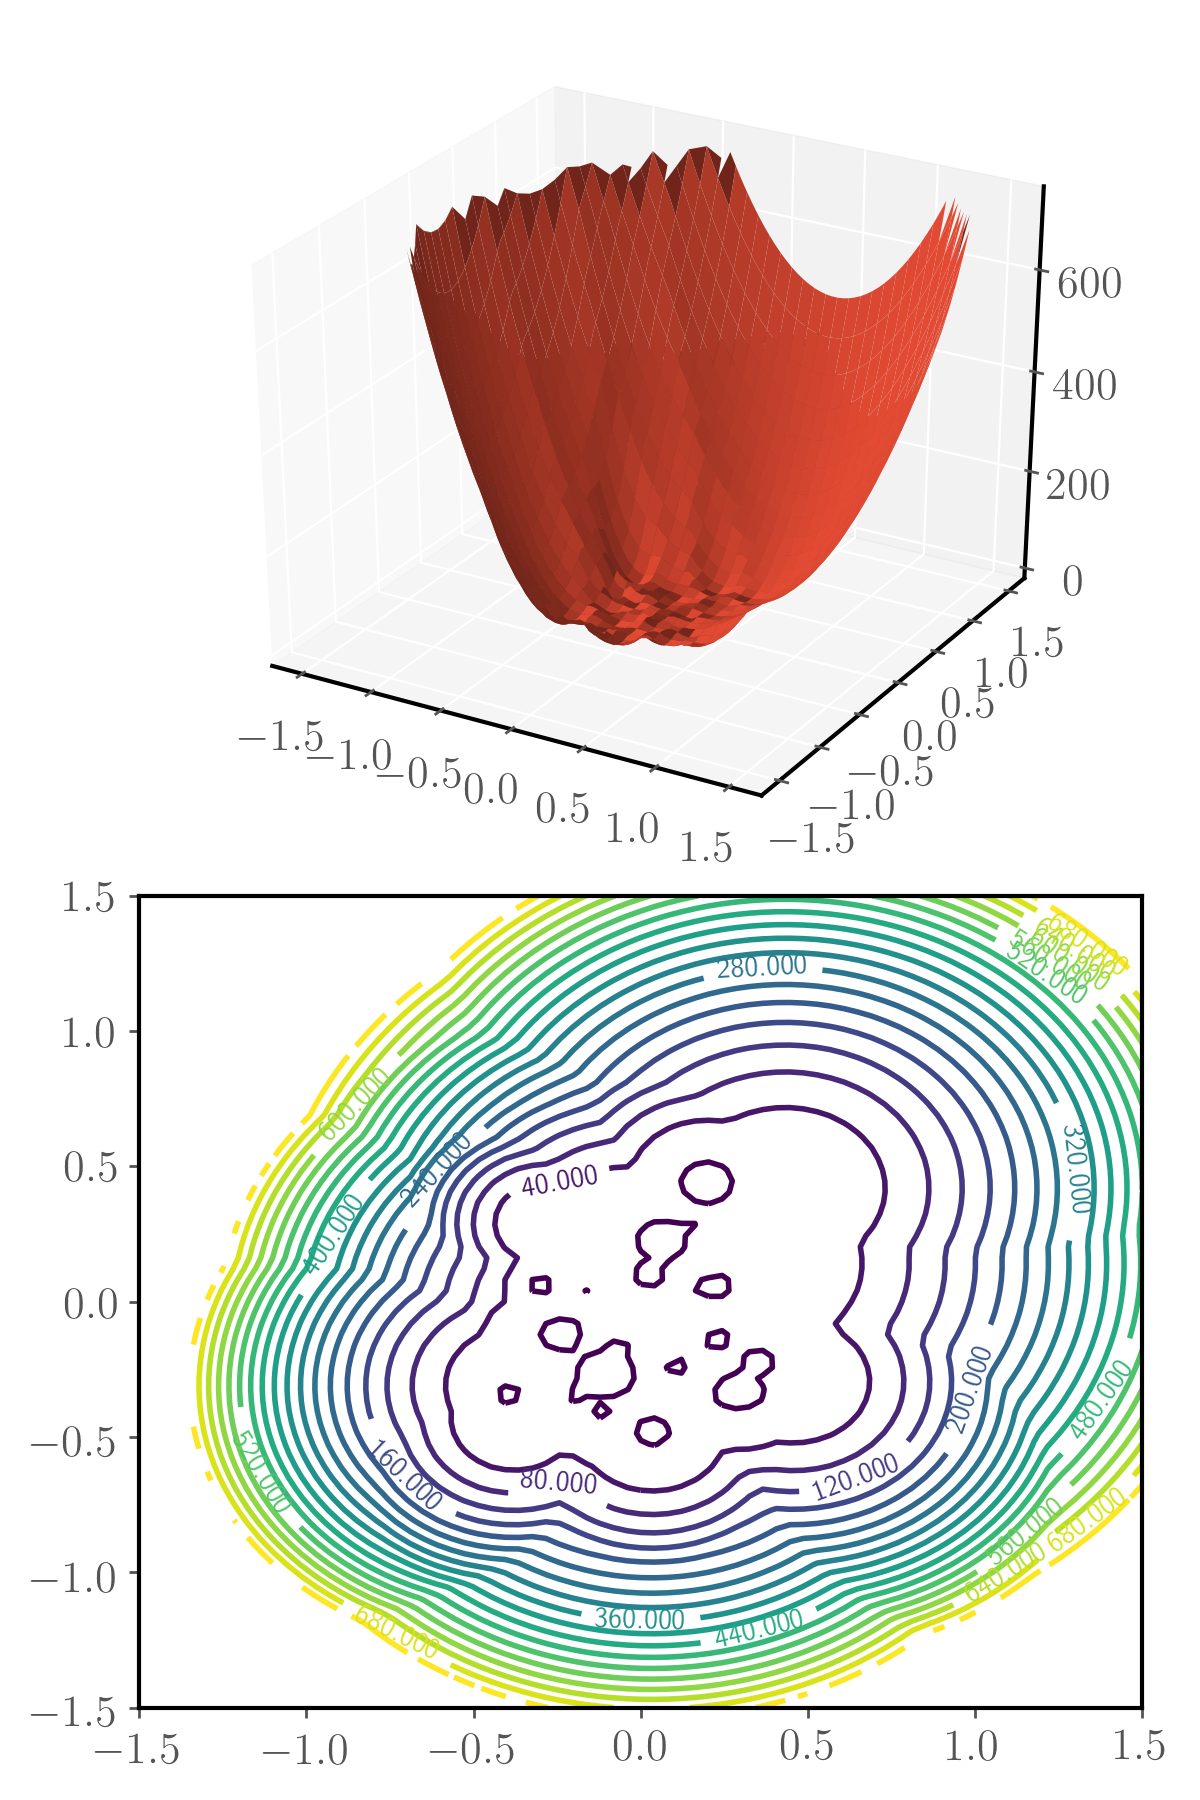

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log
/anaconda/lib/python3.6/site-packages/mpl_toolkits/mplot3d/axes3d.py:1728: RuntimeWarning: invalid value encountered in subtract
  v1[which_pt] = np.array(ps2[i1]) - np.array(ps2[i2])
/anaconda/lib/python3.6/site-packages/mpl_toolkits/mplot3d/axes3d.py:1729: RuntimeWarning: invalid value encountered in subtract
  v2[which_pt] = np.array(ps2[i2]) - np.array(ps2[i3])
/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:1770: RuntimeWarning: invalid value encountered in subtract
  cp1 -= tmp
/anaconda/lib/python3.6/site-packages/mpl_toolkits/mplot3d/axes3d.py:1784: RuntimeWarning: invalid value encountered in true_divide
  for n in normals])
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log


<a list of 23 text.Text objects>

In [6]:
d = 10
n = 50

if regenerate:
    mus = (np.random.rand(n,d)-0.5)
    sigmas = np.random.normal(0.02,0.01,size=n)
    depths = np.random.rand(n)*10

    np.savetxt("mus_{:03d}_{:03d}.dat".format(d,n),mus)
    np.savetxt("sigmas_{:03d}_{:03d}.dat".format(d,n),sigmas)
    np.savetxt("depths_{:03d}_{:03d}.dat".format(d,n),depths)

mus = np.loadtxt("mus_{:03d}_{:03d}.dat".format(d,n))
sigmas = np.loadtxt("sigmas_{:03d}_{:03d}.dat".format(d,n))
depths = np.loadtxt("depths_{:03d}_{:03d}.dat".format(d,n))

def gauss_for_plots(x, y, mu, sigma, depth):
    return np.exp(-0.5*((x-mu[0])**2+(y-mu[1])**2)/sigma**2 + depth)

def mog_for_plots(x,y,mus,sigmas,depths):
    etot = 0.
    for i in range(len(depths)):
        etot += gauss_for_plots(x, y, mus[i], sigmas[i], depths[i])
    return etot/len(depths)

xs = np.linspace(-1.5,1.5,75)
ys = np.linspace(-1.5,1.5,75)
xg,yg = np.meshgrid(xs,ys)
zg = mog_for_plots(xg,yg,mus,sigmas,depths)

fig = plt.figure(figsize=(6, 9))
ax1 = fig.add_subplot(2,1,1,projection="3d")
ax1.plot_surface(xg,yg,-np.log(zg))
ax2 = fig.add_subplot(2,1,2)
cplot = ax2.contour(xg,yg,-np.log(zg),20)
ax2.clabel(cplot, inline=1, fontsize=10)

In [7]:
import numpy as np
class StringMethod(object):

    def __init__(self, potential_func, force_func, n_iter=2000, tol=1e-7, n_image=25, dt=5e-5):
        self.n_iter = n_iter
        self.tol = tol
        self.dt = dt
        self.n_image = n_image
        self.potential = potential_func
        self.force = force_func
        
    def run_string(self, x0, x1, force_kwargs=dict()):

        interp_pts = np.linspace(0,1,self.n_image)
        string = np.outer(interp_pts,(x1-x0)) + x0
        
        for iter in range(self.n_iter):
            fs = self.force(string, **force_kwargs)
            string_init = string
            string = string - self.dt*fs
            string = self.reparam(string, interp_pts)
            if np.mean((string-string_init)**2) < self.tol:
                return string
        return string
        
    @staticmethod        
    def reparam(string, interp_pts):
        dxs = string[1:]-string[:-1]
        dxs = np.insert(dxs,0,dxs[0]*0, axis=0)
        ls = np.cumsum(np.sqrt(np.sum(dxs**2,axis=1)),axis=0)
        ls = ls/ls[-1]
        for i in range(string.shape[-1]):
            string[:,i] = np.interp(interp_pts, ls, string[:,i])
        return string
    
    def mep(self, string, force_kwargs=dict()):
        ds = np.roll(string, -1) - np.roll(string, 1)
        Vz = 0.5*np.cumsum(np.sum(-ds*self.force(string, **force_kwargs), axis=1))
        return Vz - np.min(Vz), np.max(Vz)
    

In [8]:
def gauss(xs, mu, sigma, depth):
    return np.exp(-0.5*np.sum((xs-mu)**2,axis=1)/sigma**2 + depth)

def mog(xs, mus, sigmas, depths):
    etot = np.zeros(len(xs))
    for i in range(len(depths)):
        etot += gauss(xs, mus[i], sigmas[i], depths[i])
    return -np.log(etot)

def force(xs, mus, sigmas, depths):
    fs = 0*xs
    Ntot = np.zeros(len(xs))
    for i in range(len(depths)):
        Ni = gauss(xs,mus[i],sigmas[i],depths[i])
        fs += (xs-mus[i])/(sigmas[i]**2)*Ni[:,None]
        Ntot += Ni
    return fs/Ntot[:,None]

logZmog = -np.log(np.sum(np.exp(depths)*(2*np.pi*(sigmas**2))**(d/2.)))
print("Z =",logZmog)

Z = 17.10030256279647


In [9]:
string_runner = StringMethod(mog, force, n_iter=1000, n_image=25)
force_kwargs = dict(mus=mus, sigmas=sigmas, depths=depths)
paths = []
for i in range(len(mus)-1):
    for j in range(i+1,len(mus)):
        st = string_runner.run_string(mus[i], mus[j], force_kwargs=force_kwargs)
        paths.append(st)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


In [10]:
for path in paths:
    ax2.plot(path[:,0],path[:,1])

In [11]:
def is_single_barrier(path):
    mep = mog(path, mus, sigmas, depths)
    inflections = np.diff(mep[1:] - mep[:-1] > 0)
    return np.sum(inflections) == 1, mep

In [12]:
count=0
energy_vec = np.zeros(len(mus))
barrier_mat = np.zeros([len(mus),len(mus)])
for i in range(len(mus)-1):
    for j in range(i+1,len(mus)):
        single_barrier, mep = is_single_barrier(paths[count])
        energy_vec[i] = mep[0]
        energy_vec[j] = mep[-1]
        if single_barrier:
            barrier_mat[i,j] = np.max(mep)
            barrier_mat[j,i] = barrier_mat[i,j]
        count+=1

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
# construct the adjacency matrix for the graph
adjmat=np.array(barrier_mat!=0,dtype=np.int32)

<IPython.core.display.Javascript object>


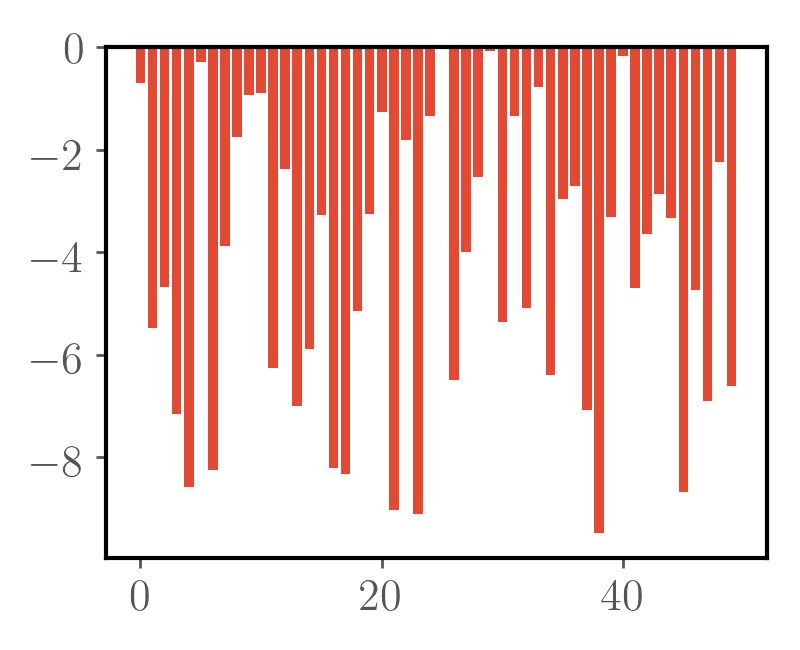

<BarContainer object of 50 artists>

In [14]:
fig,ax = plt.subplots()
ax.bar(np.argsort(energy_vec), energy_vec)

<IPython.core.display.Javascript object>


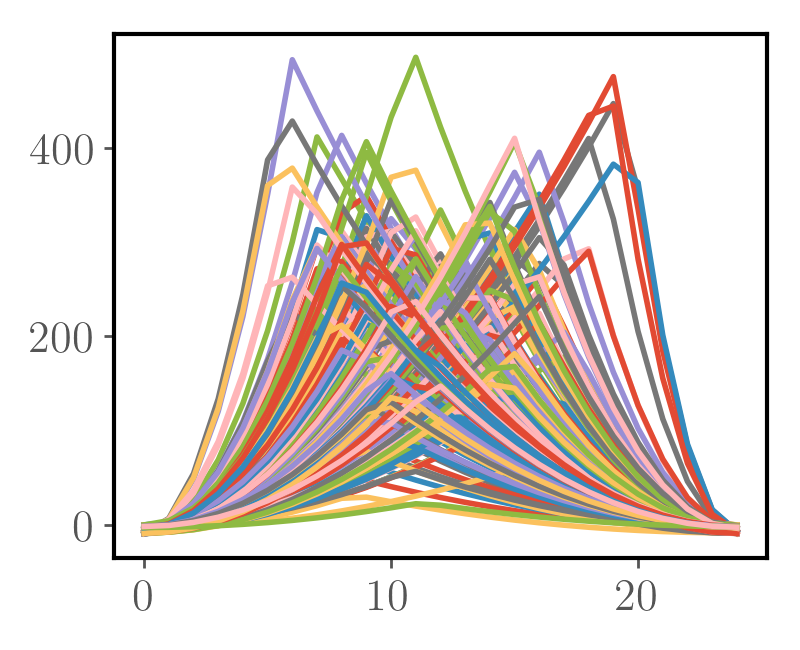

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
fig, ax = plt.subplots()
count=0
for i in range(n-1):
    for j in range(i+1, n):
        if is_single_barrier(paths[count])[0]:
            #ax = fig.add_subplot(count,1,count)
            mep = mog(paths[count],mus,sigmas,depths)
            ax.plot(mep, label="%d - %d"%(i,j))
        count+=1

In [16]:
import networkx as nx
g = nx.convert_matrix.from_numpy_matrix(barrier_mat)

<IPython.core.display.Javascript object>


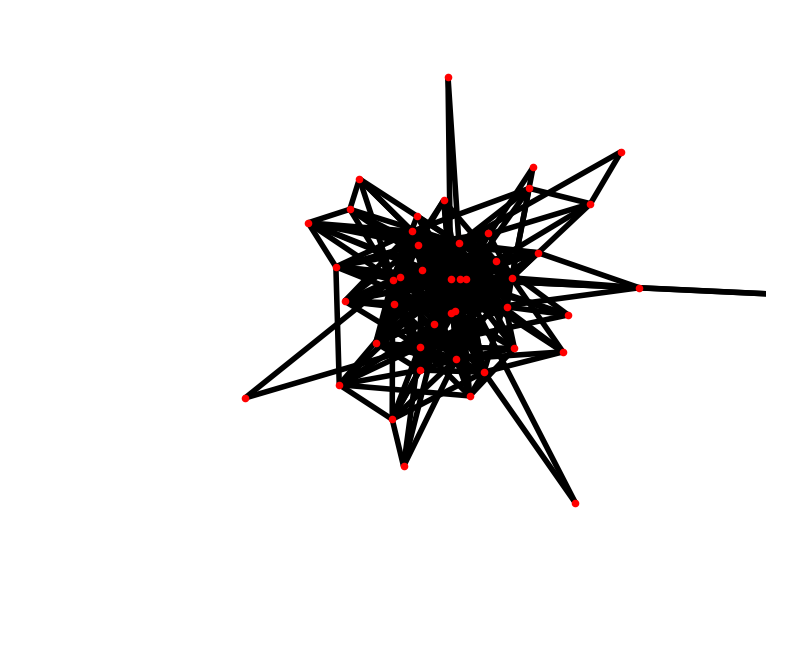

In [17]:
fig, ax = plt.subplots()
pts = np.transpose(np.array([np.linspace(0,1,len(energy_vec)), energy_vec]))
nx.draw(g, node_size=5, width=2)

# II. Analysis of Trajectorial Estimate

In [18]:
# read trajectorial estimator data
d = 10
n_traj = 100
gamma = 1
vs = np.loadtxt("mog_dim={:04d}_gamma={:4.3f}_ntraj={:04d}.dat".format(d, gamma, n_traj))

In [19]:
def base_volume(hmax, n_pts, qmin, qmax, pmin, pmax):
    qs = (qmax - qmin) * np.random.rand(n_pts,d) + qmin
    ps = (pmax - pmin) * np.random.rand(n_pts,d) + pmin
    hs = mog(qs, mus, sigmas, depths) + np.sum(ps**2,axis=1)
    return np.sum(hs<hmax)/n_pts * (qmax-qmin)**d * (2*np.sqrt(hmax))**d

def mc_vos_estimate(n_pts, qmin, qmax, pmin, pmax):
    qs = (qmax - qmin) * np.random.rand(n_pts,d) + qmin
    ps = (pmax - pmin) * np.random.rand(n_pts,d) + pmin
    hs = mog(qs, mus, sigmas, depths) + np.sum(ps**2,axis=1)
    mc_est = np.array([ np.sum(hs<h)/n_pts for h in vs[:,0]])
    return mc_est / mc_est[-1]

# estimate Z using quadrature, removing the momentum contribution
def estimate_Z(vs, base_volume):
    dvs = 0.5*(vs[2:,1]-vs[:-2,1])
    dvs = base_volume * np.concatenate([[vs[1,1]-vs[0,1]],dvs,[vs[-1,1]-vs[-2,1]]])
    return np.sum(np.exp(-vs[:,0]) * dvs) / (np.pi)**(d/2.0)

In [48]:
# NB: This step is expensive in high dimensions---may want to 
hmin = np.min(energy_vec)
hmax = 450
dh = hmax - hmin
bv = base_volume(hmax, 20000000, -1, 1, -20, 20)
print(bv)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


3869835264000.0015


In [20]:
bv = 3869835264000.0015
-np.log(estimate_Z(vs, bv)), logZmog

(17.406177642470546, 17.10030256279647)

<IPython.core.display.Javascript object>


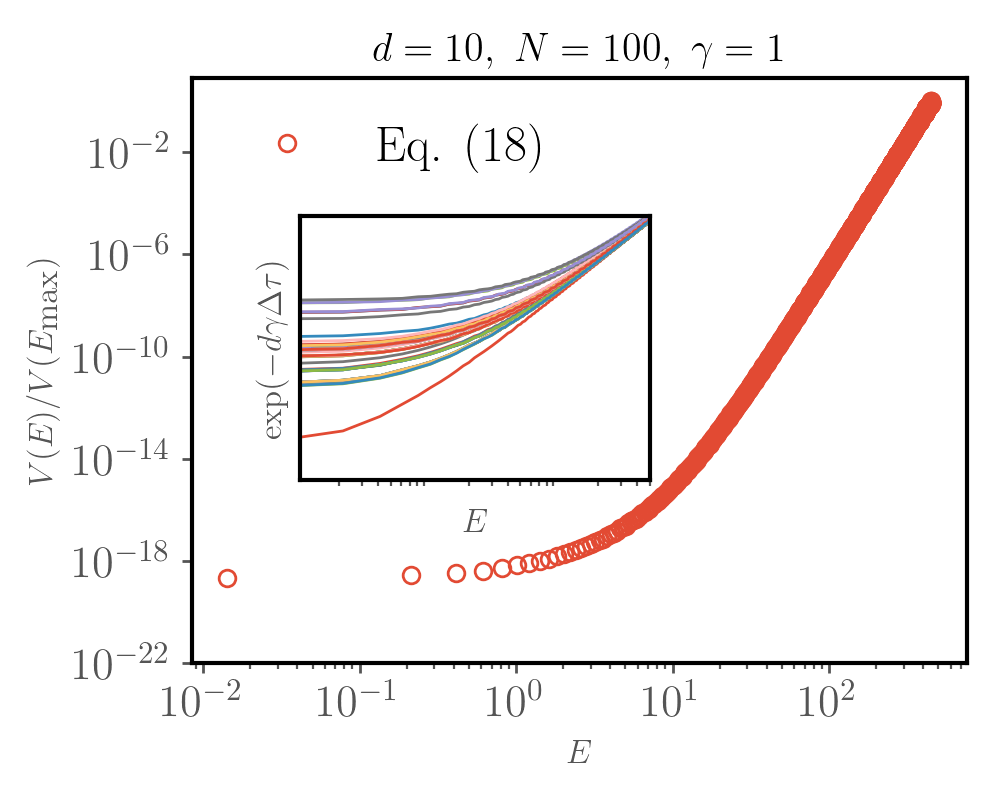

/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


In [43]:
fig, ax1 = plt.subplots(1,1, figsize=(5,4))

ax1.loglog(vs[:,0], vs[:,1], "o", label=r"$\textrm{Eq. }(18)$", markerfacecolor="None")
#ax1.loglog(vs[:,0], vs_mc, "-", color="k", label=r"$\textrm{Monte Carlo } N=10^7$")
ax1.set_xlabel("$E$")
ax1.set_ylabel(r"$V(E)/V(E_\textrm{max})$")
ax1.set_ylim([1e-22,8])

# subplot with the times
tds = np.loadtxt("../paper/figs/fig02/tdiffs.dat")
inset_ax = plt.axes([.3, .4, .35, .33])
inset_ax.set_ylim([10e-35,10e-10])
inset_ax.set_xlim([10e-2,5e1])
for row in tds:
    inset_ax.loglog(vs[:,0], np.exp(-d*gamma*row[1:]),lw=1)
    
inset_ax.set_xlabel("$E$")
inset_ax.set_ylabel(r"$\exp( - d \gamma \Delta \tau )$")
inset_ax.set_xticks([])
inset_ax.set_yticks([])
#fig.savefig("times_d={:03d}_gamma{:4.3f}.pdf".format(d, gamma))

fig.tight_layout()
ax1.legend(frameon=False)
ax1.set_title("$d={:d},\ N={:d},\ \gamma={:3.0f}$".format(d,n_traj, gamma))
fig.savefig("fig02_d={:d}_N={:d}_gamma={:3.2f}.pdf".format(d,n_traj, gamma))

In [ ]:
fig, ax1 = plt.subplots(1,1, figsize=(5,4))

ax1.loglog(vs[:,0], vs[:,1], "o", label=r"$\textrm{Eq. }(18)$", markerfacecolor="None")
#ax1.loglog(vs[:,0], vs_mc, "-", color="k", label=r"$\textrm{Monte Carlo } N=10^7$")
ax1.set_xlabel("$E$")
ax1.set_ylabel(r"$V(E)/V(E_\textrm{max})$")
ax1.set_ylim([1e-22,8])

# subplot with the times
tds = np.loadtxt("../paper/figs/fig02/tdiffs.dat")
inset_ax = plt.axes([.3, .4, .35, .33])
inset_ax.set_ylim([10e-35,10e-10])
inset_ax.set_xlim([10e-2,5e1])
for row in tds:
    inset_ax.loglog(vs[:,0], np.exp(-d*gamma*row[1:]),lw=1)
    
inset_ax.set_xlabel("$E$")
inset_ax.set_ylabel(r"$\exp( - d \gamma \Delta \tau )$")
inset_ax.set_xticks([])
inset_ax.set_yticks([])
#fig.savefig("times_d={:03d}_gamma{:4.3f}.pdf".format(d, gamma))

fig.tight_layout()
ax1.legend(frameon=False)
ax1.set_title("$d={:d}, N={:d}, \gamma={:3.2f}$".format(d,n_traj, gamma))
fig.savefig("fig02_d={:d}_N={:d}_gamma={:3.2f}.pdf".format(d,n_traj, gamma))